Start by importing and loading the data set into a variable called df (standard notation for datasets). Use df.head() to showcase the first 5 rows of the data

In [1]:
import pandas as pd

df = pd.read_csv("../data/german_credit_data.csv")

df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


Get a general knowledge of the data set

In [2]:
df.shape

(1000, 11)

In [3]:
df.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='str')

This one will show you how many missing rows there are (missing data) as well as the data type for each

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Unnamed: 0        1000 non-null   int64
 1   Age               1000 non-null   int64
 2   Sex               1000 non-null   str  
 3   Job               1000 non-null   int64
 4   Housing           1000 non-null   str  
 5   Saving accounts   817 non-null    str  
 6   Checking account  606 non-null    str  
 7   Credit amount     1000 non-null   int64
 8   Duration          1000 non-null   int64
 9   Purpose           1000 non-null   str  
 10  Risk              1000 non-null   str  
dtypes: int64(5), str(6)
memory usage: 86.1 KB


Begin by cleaning up the data. Drop unnecessary collumns

In [5]:
df = df.drop("Unnamed: 0", axis=1)
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='str')

Now, identify the missing values in your data. Begin by quantifying them.

In [6]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

Since machine cannot use "good" or "bad" for machine learning, convert to numbers. 

In [7]:
df["Risk"] = df["Risk"].map({"good": 0, "bad": 1})
df["Risk"].value_counts()

Risk
0    700
1    300
Name: count, dtype: int64

Seperate Inputs X and Y so that X is the features (inputs) and Y is the target (output). This is so the model learns patterns that map features to risk.

In [8]:
X = df.drop("Risk", axis=1)
y = df["Risk"]

print(X.shape)
print(y.shape)
print(y.value_counts())

(1000, 9)
(1000,)
Risk
0    700
1    300
Name: count, dtype: int64


Now we are going to do one-hot encoding. This will make it so our values are numerical and we can work with them. For columns with multiple values, we will split it so that each possible outcome is a seperate column and 1 and 0 will say if it is that outcome or not

In [9]:
import numpy as np

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['Age', 'Job', 'Credit amount', 'Duration']
Categorical: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


This showed all of the values that we need to transfer to numerical. Numpy just allows us to manipulate data. Now we are going to split the train data from the test data, which allows us not to leak info during this process and mess up our machine learning.
Training set → used to train the model. Test set     → used to evaluate the model

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 20% of the set goes to testing, meaning that the remaining 80% are trained
    random_state=42, # Makes it so that it is the same split everytime, 42 is arbitrary 
    stratify=y # This ensures the proportion of good vs bad borrowers stays the same in both sets
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 9)
(200, 9)
(800,)
(200,)


Now, identify categorical vs numeric columns in the training sets

In [11]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Numeric: ['Age', 'Job', 'Credit amount', 'Duration']
Categorical: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


Now, for the encoding. In this, you are appplying certain rules to either numerical or categorical data in order to change it all into small, easy to interpret numbers. All this does is change the train and test input data to be more usable.

In [12]:
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


# 1) Build a "pipeline" for numeric columns
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # fill missing numbers (NaN) with the median
    ("scaler", StandardScaler())                    # scale numeric features to make mean = 0 and std = 1
])


# 2) Build a "pipeline" for categorical columns (ONE-HOT encoding happens here)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fill missing categories with most frequent 
    ("onehot", OneHotEncoder(handle_unknown="ignore"))     # convert categories -> 0/1 columns
])


# 3) Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),      # apply numeric pipeline to numeric columns
        ("cat", categorical_transformer, categorical_features) # apply categorical pipeline to categorical columns
    ]
)


# 4) Fit on training data, transform both training and test data
X_train_processed = preprocessor.fit_transform(X_train)     # learn the rules on training data, then apply them
X_test_processed = preprocessor.transform(X_test)       # apply the learned rules to test data

print("Processed training shape:", X_train_processed.shape) 
print("Processed test shape:", X_test_processed.shape)


# 5) Get the feature names after one-hot encoding (for interpretation)
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"] # Access the fitted OneHotEncoder
cat_feature_names = ohe.get_feature_names_out(categorical_features) # Get encoded feature names

all_feature_names = np.concatenate([numeric_features, cat_feature_names]) # Combine numeric + categorical names

print("Total features after encoding:", len(all_feature_names))
print("First 30 encoded feature names:", all_feature_names[:30]) 

Processed training shape: (800, 24)
Processed test shape: (200, 24)
Total features after encoding: 24
First 30 encoded feature names: ['Age' 'Job' 'Credit amount' 'Duration' 'Sex_female' 'Sex_male'
 'Housing_free' 'Housing_own' 'Housing_rent' 'Saving accounts_little'
 'Saving accounts_moderate' 'Saving accounts_quite rich'
 'Saving accounts_rich' 'Checking account_little'
 'Checking account_moderate' 'Checking account_rich' 'Purpose_business'
 'Purpose_car' 'Purpose_domestic appliances' 'Purpose_education'
 'Purpose_furniture/equipment' 'Purpose_radio/TV' 'Purpose_repairs'
 'Purpose_vacation/others']


The next step is to train and evaluate the actual risk model.

In [13]:
from sklearn.linear_model import LogisticRegression # Used for logistic regression algorithm 
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix # Evaluation Tools

clf = LogisticRegression(max_iter=1000) # Create an empty logistic model ready to learn 

# THe max_iter=1000 just means it takes 1000 steps to optimize how much weight each variable has

# Train (fit) the model just created (actually learn the weights)
clf.fit(X_train_processed, y_train) 

# Predict Posibilities on the test set (Returns risk score)
y_proba = clf.predict_proba(X_test_processed)[:, 1] # Returns two probabilities per borrower, but only selects column of bad

# Predict Final Class labels
y_pred = clf.predict(X_test_processed) # Converts probabilities into a final decision

# Evaluate with ROC AUC
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Create a confusion Matrix:
# TN: Correctly Predicted Good                  FP: Predicted default but actually good
# FN: Predicted good but actually default       TP: Correctly predicted default
print(confusion_matrix(y_test, y_pred)) 

# Classification report
# precision: when you predict bad, how often are you right (TP / (TP + FP))
# recall: out of all actual bad, how many did you catch (TP / (TP + FN))
# f1-score: balance of precision and recall 
print(classification_report(y_test, y_pred)) 

ROC AUC: 0.6342857142857142
[[133   7]
 [ 44  16]]
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       140
           1       0.70      0.27      0.39        60

    accuracy                           0.74       200
   macro avg       0.72      0.61      0.61       200
weighted avg       0.73      0.74      0.70       200



The ROC AUC does not mean 63% accurate, it means that the model ranks risky borrowers above safe borrowers 63% of the time. This shows that the current model is conservative, rarely flags borrowers as bad, good at approving safe borrowers, bad at catching risky borrowers. This is normal due to an imbalanced (70% good) dataset. Now, we are going to try to lower the threshold, recompute confusion matrix, and then see how the recall improves.

In [14]:
import numpy as np

y_pred_03 = (y_proba >= 0.3).astype(int) # Change the threshold to 0.3 instead of 0.5

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_03))
print(classification_report(y_test, y_pred_03)) 

[[91 49]
 [27 33]]
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       140
           1       0.40      0.55      0.46        60

    accuracy                           0.62       200
   macro avg       0.59      0.60      0.59       200
weighted avg       0.66      0.62      0.63       200



With this new threshold, we are now catching more bad borrowers, but also rejecting more good borrowers. Now we are going to generate the ROC Curve

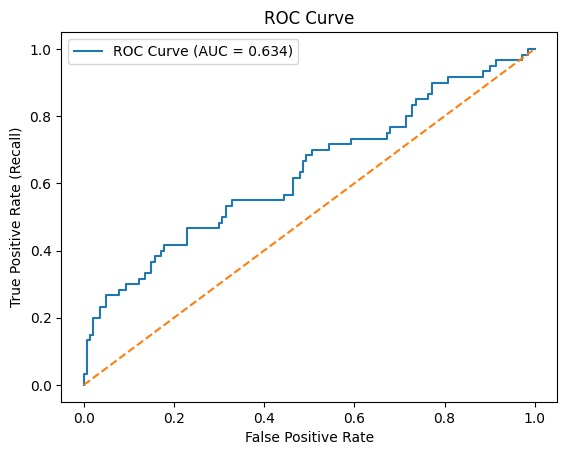

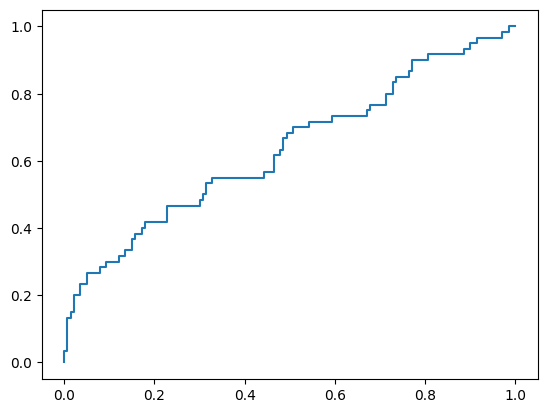

In [15]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve values
# fpr → false positive rate for every threshold
# tpr → recall for every threshold
# thresholds → the probability cutoffs tested
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.3f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], linestyle="--")  # random model line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.savefig("../images/roc_curve.png", bbox_inches="tight") # add image to folder
plt.show()

plt.figure()
plt.plot(fpr, tpr)


The further right we are, the more good borrowers we are accidently rejecting. The further up we are, the more bad borrowers we are rejecting correctly. The goal is to get to the top left, which is the best possible combination. Now we are going to try to find the optimal threshold by computing Youden's J statistic. This is maximizing the highest TPR and the lowest FPR at every threshold.

In [16]:
import numpy as np

# Youden's J = TPR - FPR
j_scores = tpr - fpr

best_index = np.argmax(j_scores) # Get the index of the maximum value.
best_threshold = thresholds[best_index] # Get the threshold at that location 

print("Best threshold (Youden's J):", best_threshold)
print("TPR at best threshold:", tpr[best_index])
print("FPR at best threshold:", fpr[best_index])

Best threshold (Youden's J): 0.39162609728292797
TPR at best threshold: 0.4166666666666667
FPR at best threshold: 0.17857142857142858


This means the best Threshold to to maximize both TPR and FPR at the same time is at 0.392. Its the middle point, meaning you are catching less bad borrowers but accepting more good borrowers. A bank would say "Model discrimination is moderate. Threshold 0.39 provides acceptable balance between credit loss prevention and approval volume.” Now we are going to evaluate confusion matrix at optimal threshold. 

In [17]:
y_pred_opt = (y_proba >= best_threshold).astype(int)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_opt))

[[115  25]
 [ 35  25]]


What this means: 35 bad / 150 approved ≈ 23% which is still considered high risk. Now lets learn what drives risk but analyzing the features. Let's begin by extracting model coefficients to find weight. 

In [18]:
import pandas as pd

coefficients = clf.coef_[0] # This retrieves the learned weights from logistic regression (row 1 and it only has one row)

# Combine weights with feature names 
feature_importance = pd.DataFrame({ 
    "Feature": all_feature_names,
    "Coefficient": coefficients
}) 

# Sort by coeffcient value (most risk increasing to most risk reducing)
feature_importance = feature_importance.sort_values(
    by="Coefficient",
    ascending=False
)

feature_importance.head(15)

,Feature,Coefficient
19,Purpose_education,0.616638
9,Saving accounts_little,0.470957
3,Duration,0.466262
10,Saving accounts_moderate,0.415416
22,Purpose_repairs,0.363939
14,Checking account_moderate,0.299206
8,Housing_rent,0.224347
4,Sex_female,0.179730
20,Purpose_furniture/equipment,0.099496
6,Housing_free,0.089704


This prints all of the created features and their weight to increasing risk. Positive coefficient just means that it increases probability of default, and negative decreases probability of default. Now lets see the top 15 most risk reducing features. 

In [19]:
feature_importance.tail(15)

,Feature,Coefficient
6,Housing_free,0.089704
18,Purpose_domestic appliances,0.049486
17,Purpose_car,-0.027243
2,Credit amount,-0.043111
1,Job,-0.051407
0,Age,-0.064093
15,Checking account_rich,-0.085805
16,Purpose_business,-0.171073
5,Sex_male,-0.176364
13,Checking account_little,-0.210035


Next major upgrade is to convert coefficients → Odds Ratios, which allows the data to be readable. Logistic regression coefficients are in log-odds. If we exponentiate them, we get an odds ratio. 

odds ratio = e^b

- OR > 1 -> increases odds of being bad
- OR < 1 -> decreases odds of being bad
- OR = 1 -> no effect

For example, if b = 0.62 -> OR = e^0.62 ~~ 1.86 -> ~86% higher odds.


In [20]:
import numpy as np
import pandas as pd

# feature_importance already has Feature + Coefficient
feature_importance["Odds_Ratio"] = np.exp(feature_importance["Coefficient"]) # Turn them into OR
feature_importance["Pct_Change_Odds"] = (feature_importance["Odds_Ratio"] - 1) * 100 # Express as a percentage change

# show the most risk-increasing (largest coefficients)
feature_importance.head(15)

,Feature,Coefficient,Odds_Ratio,Pct_Change_Odds
19,Purpose_education,0.616638,1.852690,85.268971
9,Saving accounts_little,0.470957,1.601526,60.152625
3,Duration,0.466262,1.594025,59.402454
10,Saving accounts_moderate,0.415416,1.515001,51.500088
22,Purpose_repairs,0.363939,1.438987,43.898660
14,Checking account_moderate,0.299206,1.348788,34.878798
8,Housing_rent,0.224347,1.251505,25.150471
4,Sex_female,0.179730,1.196894,19.689368
20,Purpose_furniture/equipment,0.099496,1.104614,10.461411
6,Housing_free,0.089704,1.093851,9.385067


Now, we are going to show the most protective features

In [21]:
feature_importance.tail(15)

,Feature,Coefficient,Odds_Ratio,Pct_Change_Odds
6,Housing_free,0.089704,1.093851,9.385067
18,Purpose_domestic appliances,0.049486,1.050731,5.073113
17,Purpose_car,-0.027243,0.973124,-2.687562
2,Credit amount,-0.043111,0.957805,-4.219455
1,Job,-0.051407,0.949892,-5.010773
0,Age,-0.064093,0.937918,-6.208219
15,Checking account_rich,-0.085805,0.917773,-8.222695
16,Purpose_business,-0.171073,0.842760,-15.723979
5,Sex_male,-0.176364,0.838313,-16.168703
13,Checking account_little,-0.210035,0.810556,-18.944447


Make a clean "risk drivers" table.

In [22]:
top_up = feature_importance.sort_values("Coefficient", ascending=False).head(8)[
    ["Feature", "Coefficient", "Odds_Ratio", "Pct_Change_Odds"]
]

top_down = feature_importance.sort_values("Coefficient", ascending=True).head(8)[
    ["Feature", "Coefficient", "Odds_Ratio", "Pct_Change_Odds"]
]

print("Top risk-increasing drivers:")
display(top_up)

print("\nTop risk-reducing drivers:")
display(top_down)

Top risk-increasing drivers:


,Feature,Coefficient,Odds_Ratio,Pct_Change_Odds
19,Purpose_education,0.616638,1.852690,85.268971
9,Saving accounts_little,0.470957,1.601526,60.152625
3,Duration,0.466262,1.594025,59.402454
10,Saving accounts_moderate,0.415416,1.515001,51.500088
22,Purpose_repairs,0.363939,1.438987,43.898660
14,Checking account_moderate,0.299206,1.348788,34.878798
8,Housing_rent,0.224347,1.251505,25.150471
4,Sex_female,0.179730,1.196894,19.689368



Top risk-reducing drivers:


,Feature,Coefficient,Odds_Ratio,Pct_Change_Odds
12,Saving accounts_rich,-0.632985,0.531004,-46.899563
23,Purpose_vacation/others,-0.469202,0.625501,-37.449900
21,Purpose_radio/TV,-0.458676,0.632120,-36.787968
7,Housing_own,-0.310685,0.732945,-26.705526
11,Saving accounts_quite rich,-0.250022,0.778783,-22.121654
13,Checking account_little,-0.210035,0.810556,-18.944447
5,Sex_male,-0.176364,0.838313,-16.168703
16,Purpose_business,-0.171073,0.842760,-15.723979


Ok now lets interpret this information like a credit risk report:

**Highest Risk Inducing Features** 

**1. Purpose_education (+0.62)**

**+85% higher odds**

Interpretation: Loans taken for education purposes are associated with higher default probability.

Possible economic explanation: 
- Uncertain future income.
- Delayed repayment capacity.
- student borrowers often liquidity constrained.

**2. Saving accounts_little (+0.47)**

**60% higher odds**

Interpretation: Borrowers with limited savings show elevated credit risk.

- This is one of the strongest classic credit indicators.
- Low liquidity → higher default probability.
- Banks heavily rely on this signal.

**3. Duration (+0.47)**

**+59% higher odds (per 1 standard deviation)**

Interpretation: Longer loan duration significantly increases default risk.

Why? 
- Longer exposure window = more chances of financial distress.
- This appears in almost every consumer credit model.

**4. Saving accounts_moderate (0.41)**

**+51% higher odds**

Interesting insight: Even moderate savings still increase risk relative to rich savings.

- rich savings = safest
- moderate/little = progressively riskier

This model learned a liquidity gradient.

**5. Purpose_repairs (+0.36)**

**+44% higher odds**

Interpretation: Repair loans may indicate financial stress or unexpected expenses.

Often rorrelated with weaker financial stability

**6. Checking account_moderate (+0.30)** 

**+35% higher odds**

Interpretation: Moderate checking balance is risker than rich accounts.

Again -- liquidity matters.

**7. Housing_rent (+0.22)**

**+25% higher odds**

Interpretation: Renters tend to have higher risk than homeowners.

- Common real_world finding.
- Housing ownership proxies wealth stability

**8. Sex_female (+0.18)**

Caution: This does not mean gender causes risk

It means: In this dataset, gender correlates with other financial characteristics.

- Modern credit models often remove protected attributes for fariness/regulatory reasons.
- Good things to notice academically. 

**Strongest Risk-Reducing Features**

**1. Saving account_rich (-0.63)**

**+47% lower odds**

Interpretation: Strong savings dramatically reduce default probability.

Liquidity is king in credit risk.

**2. Purpose_vacation/others (-0.47)**

**+37% lower odds**

Interpretation: Often discretionary spending borrowers have stronger finances

Counterintuitive but common in data.

**3. Purpose_radio/TV (-0.46)**

**+37% lower odds**

Interpretation: Likely smaller consumer purchases -> manageable debt burden.

**4. Housing_own (-0.31)**

**+27% lower odds**

Interpretation: Home ownership strongly reduces risk.

Very realistic economics signal.

**5. Saving accounts_quite rich (-0.25)**

**22% lower odds**

Again, this confirms liquidity gradient learned by model.

**6. Checking account_little (-0.21)**

**+19% lower odds**

This looks surprising.

Possible explanations:
- Interaction effects
- Dataset noise
- Small sample size

Small datasets often produce mixed signals.

**Biggest Professional Insight**

**1. Liquidity dominates risk**

Savings + checking accounts are stronger predictors.

Exactly matches real banking models.

**2. Loan purpose matters**

Some borrowing motives correlate strongly with repayment behavior.

Behavioral finance signal.

**3. Stability indicators reduce risk**

Ownership + wealth proxies lower default likelihood.




Now, we are going to transofmr the work into a real data science / risk analyst portfolio project. The three layers are visualization, business interpretation chart, portfolio/github write-up.

Lets start with creating a Risk Driver Visualization. Employers do not read tables first, they look for visuals, so we are going to plot the strongest drivers of risk.

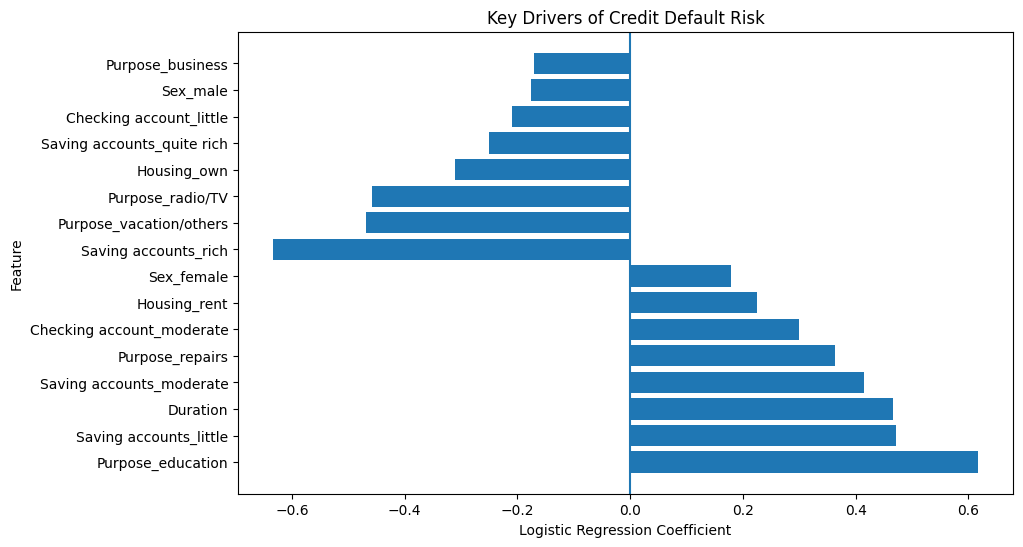

In [23]:
import matplotlib.pyplot as plt # Used for visualization

# Select top risk increasing and decreasing (first 8)
top_positive = feature_importance.sort_values(
    "Coefficient", ascending=False
).head(8)

top_negative = feature_importance.sort_values(
    "Coefficient", ascending=True
).head(8)

plot_df = pd.concat([top_positive, top_negative]) # Combine both groups

# Plot
plt.figure(figsize=(10,6)) # Width and height in inches

plt.barh( # Horizontal bar chart
    plot_df["Feature"], # Y axis
    plot_df["Coefficient"] # X axis
)

plt.axvline(0)  # zero reference line
plt.title("Key Drivers of Credit Default Risk")
plt.xlabel("Logistic Regression Coefficient")
plt.ylabel("Feature")
plt.savefig("../images/risk_drivers.png", bbox_inches="tight") # add image to folder

plt.show()


Now, we are going to show the visualization in business language, using percentage rather than math.

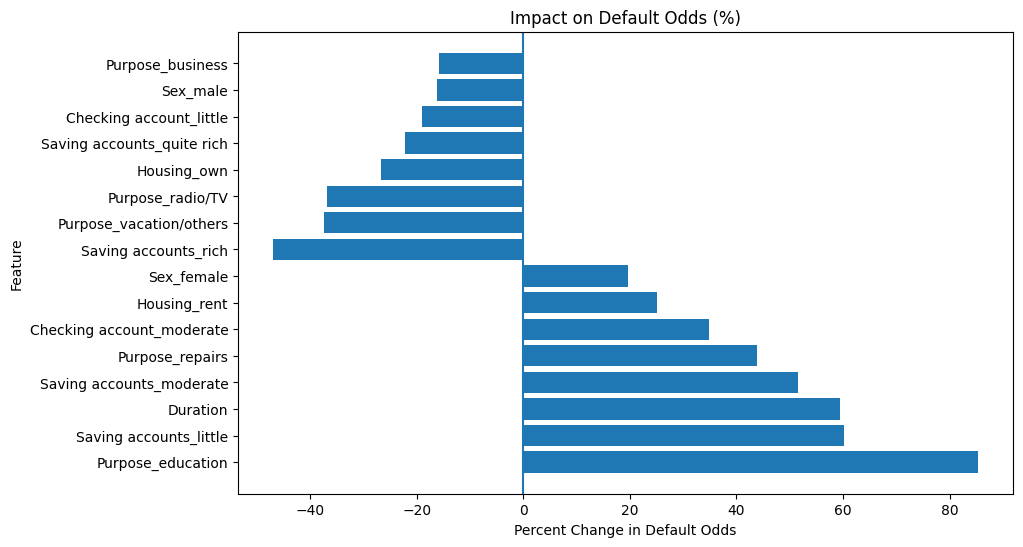

In [24]:
plt.figure(figsize=(10,6))

plt.barh(
    plot_df["Feature"],
    plot_df["Pct_Change_Odds"]
)

plt.axvline(0)
plt.title("Impact on Default Odds (%)")
plt.xlabel("Percent Change in Default Odds")
plt.ylabel("Feature")

plt.savefig("../images/risk_drivers.png", bbox_inches="tight") # add image to folder

plt.show()



## Business Interpretation

Using the optimized threshold of 0.39:

- True Positive Rate: 41.7%
- False Positive Rate: 17.9%

This implies the bank correctly flags 42% of high-risk borrowers
while incorrectly rejecting ~18% of safe applicants.

Management must balance:
- Default loss reduction
- Lost interest revenue
- Customer acquisition impact